## NVIDIA 加速推理平台介绍 ：https://build.nvidia.com/
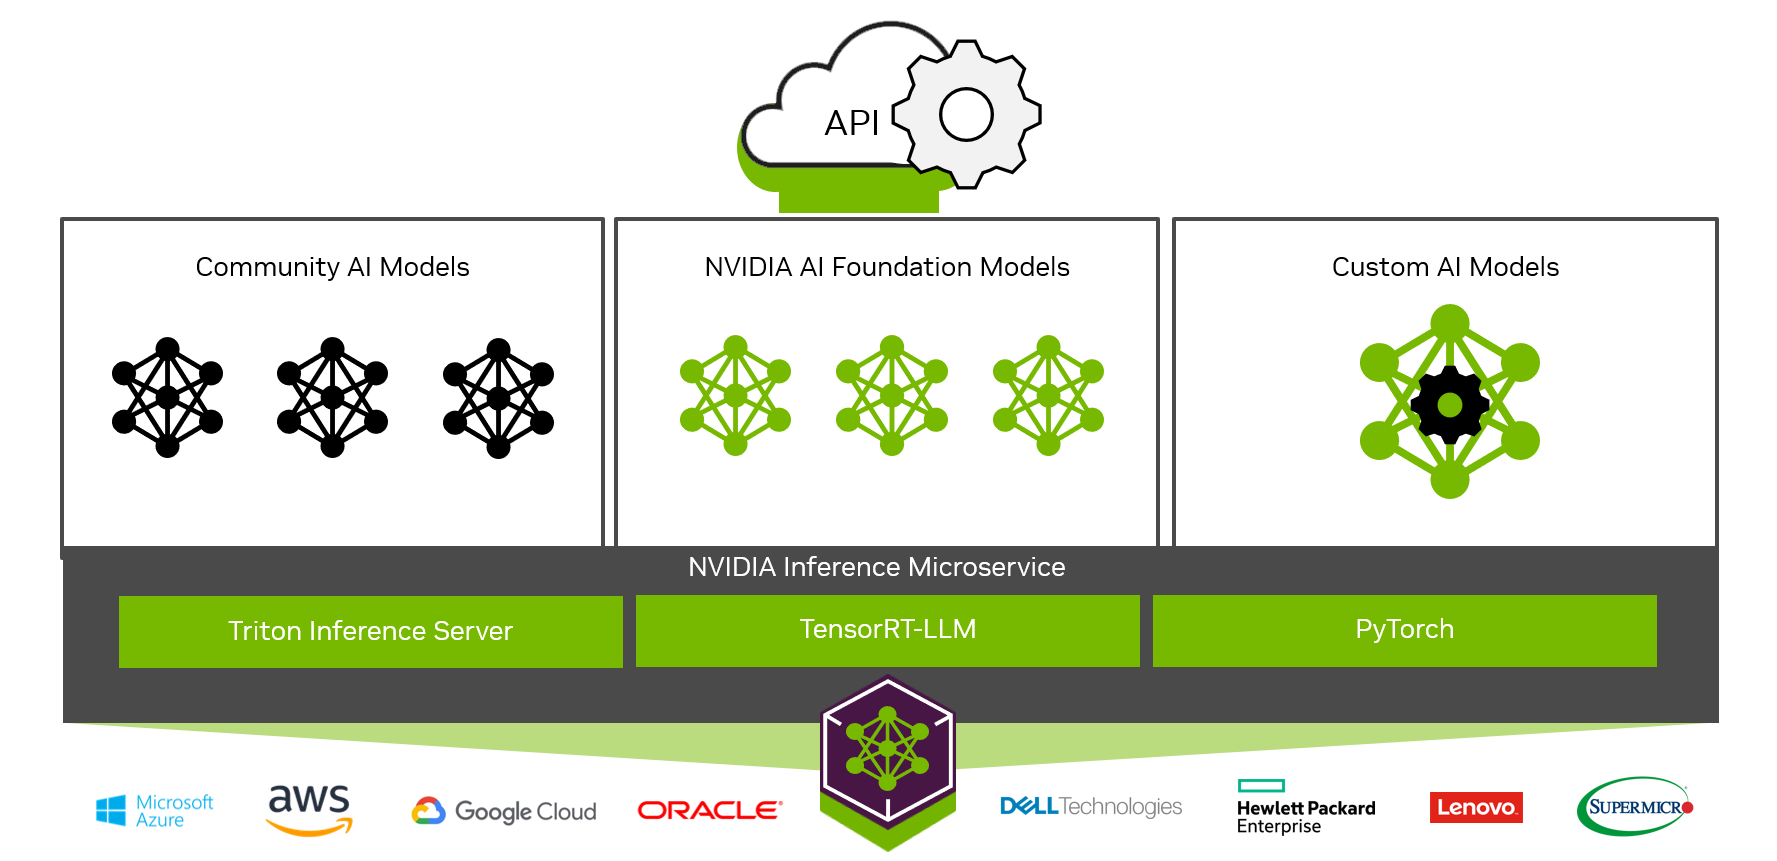

In [1]:
from openai import OpenAI

client = OpenAI(
  base_url = "https://integrate.api.nvidia.com/v1",
  api_key = "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"
)

completion = client.chat.completions.create(
  model="meta/llama-3.1-405b-instruct",
  messages=[{"role":"user","content":"泰坦尼克号的导演是谁"}],
  temperature=0.2,
  top_p=0.7,
  max_tokens=1024,
  stream=True
)

for chunk in completion:
  if chunk.choices[0].delta.content is not None:
    print(chunk.choices[0].delta.content, end="")


詹姆斯·卡梅隆

---
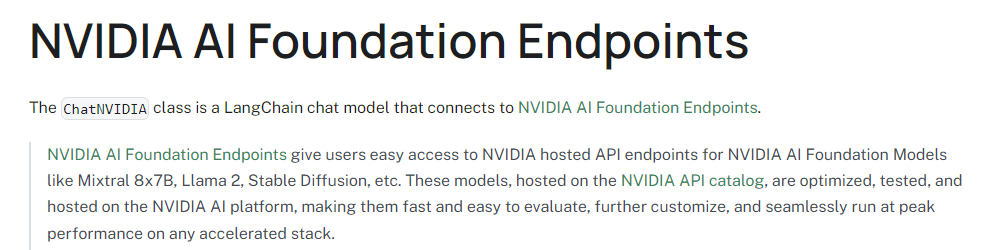
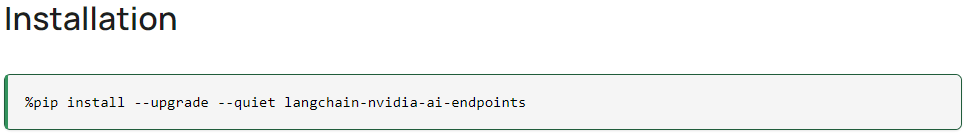
https://python.langchain.com/v0.1/docs/integrations/chat/nvidia_ai_endpoints/#rag-context-models

In [2]:
#!pip install faiss-cpu # replace with faiss-gpu if you are using GPU

### Step 1  - 使用NVIDIA_API_KEY

In [3]:
import getpass
import os

if os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    print("Valid NVIDIA_API_KEY already in environment. Delete to reset")
else:
    nvapi_key = getpass.getpass("NVAPI Key (starts with nvapi-): ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key

NVAPI Key (starts with nvapi-):  ········


In [4]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
ChatNVIDIA.get_available_models()

[Model(id='microsoft/kosmos-2', model_type='vlm', client='ChatNVIDIA', endpoint='https://ai.api.nvidia.com/v1/vlm/microsoft/kosmos-2', aliases=['ai-microsoft-kosmos-2', 'playground_kosmos_2', 'kosmos_2'], supports_tools=False, base_model=None),
 Model(id='google/gemma-2b', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=['ai-gemma-2b', 'playground_gemma_2b', 'gemma_2b'], supports_tools=False, base_model=None),
 Model(id='writer/palmyra-med-70b', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=['ai-palmyra-med-70b'], supports_tools=False, base_model=None),
 Model(id='mediatek/breeze-7b-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=['ai-breeze-7b-instruct'], supports_tools=False, base_model=None),
 Model(id='meta/llama-3.1-70b-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=None, supports_tools=True, base_model=None),
 Model(id='google/codegemma-7b', model_type='chat', client='ChatNVIDIA', endpoint=None, 

### Step 2 - 初始化SLM
**这里我们使用 phi-3-small-128k-instruct** 

In [5]:
llm = ChatNVIDIA(model="ai-phi-3-small-128k-instruct", nvidia_api_key=nvapi_key, max_tokens=512)
result = llm.invoke("泰坦尼克号的导演是谁？")
print(result.content)

/home/nvidia/.local/lib/python3.8/site-packages/langchain_nvidia_ai_endpoints/_statics.py:545: UserWarning: Model ai-phi-3-small-128k-instruct is deprecated. Using microsoft/phi-3-small-128k-instruct instead.
  warnings.warn(


 《泰坦尼克号》的导演是乔治·哈维（George Lucas）。这部电影于1977年上映，由乔治·哈维执导，且由雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·格林斯特（Raymond Wagner）、雷·


## RAG的工作流程
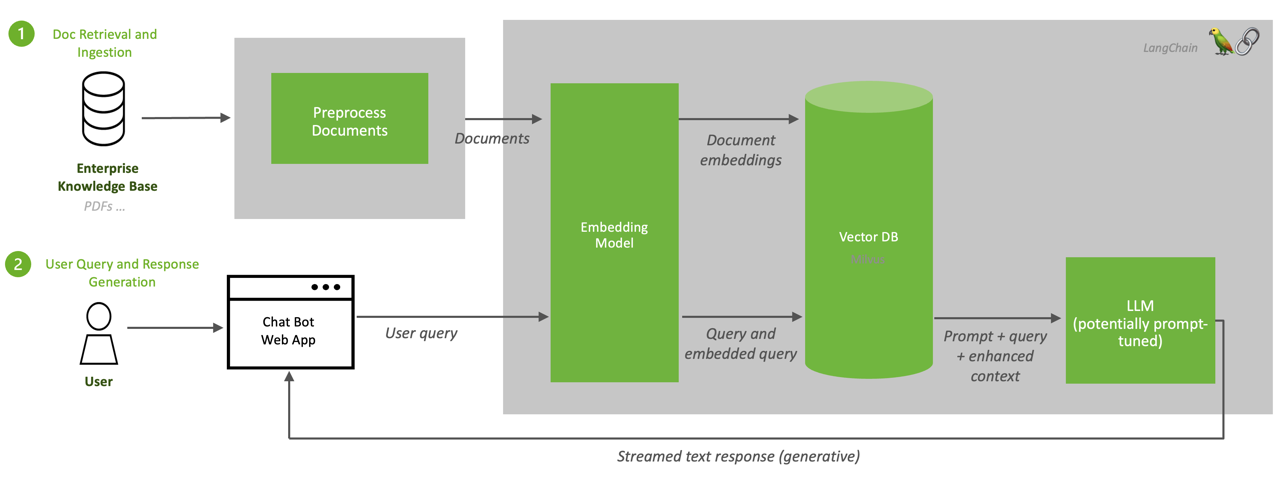

### Step 3 - 初始化ai-embed-qa-4向量模型

In [6]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings

embedder = NVIDIAEmbeddings(model="ai-embed-qa-4")

/home/nvidia/.local/lib/python3.8/site-packages/langchain_nvidia_ai_endpoints/_statics.py:545: UserWarning: Model ai-embed-qa-4 is deprecated. Using NV-Embed-QA instead.
  warnings.warn(


### Step 4 - 获取文本数据集

In [7]:
import os
from tqdm import tqdm
from pathlib import Path

# Here we read in the text data and prepare them into vectorstore
ps = os.listdir("./zh_data/")
data = []
sources = []
for p in ps:
    if p.endswith('.txt'):
        path2file="./zh_data/"+p
        with open(path2file,encoding="utf-8") as f:
            lines=f.readlines()
            for line in lines:
                if len(line)>=1:
                    data.append(line)
                    sources.append(path2file)

### Step 5 - 进行一些基本的清理并删除空行

In [8]:
documents=[d for d in data if d != '\n']
len(data), len(documents), data[0]

(1,
 1,
 '泰坦尼克号是一部 1997 年美国史诗爱情灾难片，由詹姆斯·卡梅隆执导、编剧、制作和联合剪辑。该片以 1912 年泰坦尼克号沉没事件为基础，融合了历史和虚构的元素。凯特·温斯莱特和莱昂纳多·迪卡普里奥饰演不同社会阶层的成员，他们在泰坦尼克号的处女航中坠入爱河。比利·赞恩、凯西·贝茨、弗朗西斯·费舍尔、格洛丽亚·斯图尔特、伯纳德·希尔、乔纳森·海德、维克多·加伯和比尔·帕克斯顿也参演了这部电影。\\n卡梅隆的这部电影的灵感来自于他对沉船的迷恋。他认为，一个夹杂着人员伤亡的爱情故事对于传达灾难的情感影响至关重要。该片于 1995 年 9 月 1 日开始拍摄，当时卡梅隆拍摄了泰坦尼克号沉船的实际镜头。研究船上的现代场景是在卡梅伦拍摄沉船时使用的 Akademik Mstislav Keldysh 号上拍摄的。使用比例模型、计算机生成的图像以及巴哈工作室建造的泰坦尼克号重建模型来重现沉没过程。该片由派拉蒙影业和二十世纪福克斯公司共同资助；前者负责在北美发行，而后者则在国际上发行影片。这是当时制作成本最高的电影，制作预算为 2 亿美元。拍摄时间为1996年7月至1997年3月。\\n《泰坦尼克号》于 1997 年 12 月 19 日上映。它因其视觉效果、表演（尤其是迪卡普里奥、温斯莱特和斯图尔特的表演）、制作价值、导演、配乐、摄影、故事和情感深度而受到好评。除其他奖项外，它获得了14项奥斯卡金像奖提名，并赢得了11项奖项，其中包括最佳影片和最佳导演，追平了《宾虚》（1959 年），成为获得奥斯卡奖最多的电影。 《泰坦尼克号》的全球首映票房超过 18.4 亿美元，是第一部突破 10 亿美元大关的电影。它是有史以来票房最高的电影，直到卡梅隆的下一部电影《阿凡达》(2009 年) 在 2010 年超越了它。经过多次重新上映，该电影的全球总票房达到 22.57 亿美元，成为第二部票房收入超过 100 万美元的电影。 《阿凡达》之后全球票房达到 20 亿美元。它于2017年被选入美国国家电影登记处保存。')

### Step 6a - 将文档处理到 faiss vectorstore 并将其保存到磁盘

In [9]:
# Here we create a vector store from the documents and save it to disk.
from operator import itemgetter
from langchain.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.text_splitter import CharacterTextSplitter
from langchain_nvidia_ai_endpoints import ChatNVIDIA
import faiss

In [10]:
# 只需要执行一次，后面可以重读已经保存的向量存储
# text_splitter = CharacterTextSplitter(chunk_size=400, separator=" ")
# docs = []
# metadatas = []

# for i, d in enumerate(documents):
#     splits = text_splitter.split_text(d)
#     #print(len(splits))
#     docs.extend(splits)
#     metadatas.extend([{"source": sources[i]}] * len(splits))

# store = FAISS.from_texts(docs, embedder , metadatas=metadatas)
# store.save_local('./zh_data/nv_embedding')

### Step 6b - 重读之前处理并保存的 Faiss Vectore 存储

In [11]:
# Load the vectorestore back.
store = FAISS.load_local("./zh_data/nv_embedding", embedder,allow_dangerous_deserialization=True)

### Step 7- 提出问题并基于phi-3-small-128k-instruct模型进行RAG检索

In [12]:
retriever = store.as_retriever()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer solely based on the following context:\n<Documents>\n{context}\n</Documents>",
        ),
        ("user", "{question}"),
    ]
)

chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

chain.invoke("泰坦尼克号的导演是谁？")

' 泰坦尼克号的导演是詹姆斯·卡梅隆。'

* NVIDIA AI Endpoint介绍页面： https://python.langchain.com/v0.1/docs/integrations/chat/nvidia_ai_endpoints/
* NVIDIA NIM页面： https://build.nvidia.com/explore/discover
* NVIDIA DLI课程学习资料页面：https://www.nvidia.cn/training/online/
------------------

![](https://v.png.pub/imgs/2024/06/24/d64b7856c05fa5d4.png)
